In [ ]:
# Imports gerais
import requests
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from typing import Union, List, Tuple, Dict, Any

### API do Statsbomb - para pegar os match-id

In [ ]:
!pip install statsbombpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.7/70.7 kB 3.6 MB/s eta 0:00:00


In [ ]:
from statsbombpy import sb
import pandas as pd

# (Silencia avisos comuns da biblioteca)
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='statsbombpy.api_client')

# --- 1. Veja TODAS as competições disponíveis ---
print("Buscando competições...")
competicoes_df = sb.competitions()

# Filtra para mostrar apenas as colunas úteis
print(competicoes_df[['competition_name', 'season_name', 'competition_id', 'season_id']])

# --- 2. Escolha uma competição e pegue os IDs das partidas ---

# Exemplo: Vamos pegar todas as partidas da Copa do Mundo de 2018
# Olhando a tabela acima, vemos que é:
# competition_id = 43
# season_id = 3

COMP_ID_DESEJADA = 9
SEASON_ID_DESEJADA = 27

print(f"\nBuscando partidas para Competition ID: {COMP_ID_DESEJADA}, Season ID: {SEASON_ID_DESEJADA}...")
partidas_df = sb.matches(competition_id=COMP_ID_DESEJADA, season_id=SEASON_ID_DESEJADA)

# --- 3. Extraia sua lista de IDs! ---
lista_de_ids_para_processar = partidas_df['match_id'].tolist()

print(f"Encontrado {len(lista_de_ids_para_processar)} IDs de partidas.")
print(lista_de_ids_para_processar)

# Exemplo de saída:
# Encontrado 64 IDs de partidas.
# [7580, 7570, 7553, 7545, 7567, 7566, 7552, 7543, ...]

Buscando competições...
          competition_name season_name  competition_id  season_id
0            1. Bundesliga   2023/2024               9        281
1            1. Bundesliga   2015/2016               9         27
2   African Cup of Nations        2023            1267        107
3         Champions League   2018/2019              16          4
4         Champions League   2017/2018              16          1
..                     ...         ...             ...        ...
70      UEFA Europa League   1988/1989              35         75
71       UEFA Women's Euro        2025              53        315
72       UEFA Women's Euro        2022              53        106
73       Women's World Cup        2023              72        107
74       Women's World Cup        2019              72         30

[75 rows x 4 columns]

Buscando partidas para Competition ID: 9, Season ID: 27...
Encontrado 306 IDs de partidas.
[3890561, 3890505, 3890511, 3890515, 3890411, 3890397, 3890401, 38903

# Pipeline Completa


#### Função de Request - Statsbomb

In [ ]:
def import_and_clean(
    match_id: Union[str, int],
    drop_name: bool = False
    ) -> pd.DataFrame:
    """
    Função responsável por carregar e organizar os dados de uma partida específica
    do StatsBomb a partir de seu identificador (match_id).

    O resultado é um DataFrame completo e estruturado, contendo todos os eventos
    e informações associadas à partida.
    A função também oferece a opção de remover colunas com sufixo _name, o que é útil para
    alternar entre:

    Modo de tratamento de dados → manter apenas colunas com _id (mais leves e
                                    consistentes para análise).
    Modo de visualização → manter também as colunas _name (mais legíveis para
                            inspeção e interpretação dos dados).

    Args:
        match_id (Union[str, int]): Identificador da partida no dataset do StatsBomb.
        drop_name (bool, opcional): Se True, remove todas as colunas que terminam com _name.
                                    Padrão: False.

    Returns:
        pd.DataFrame: DataFrame contendo todos os eventos e informações da partida,
                      já organizados e com as colunas ajustadas conforme o
                      parâmetro drop_name.
    """
    # Garante que match_id seja string para a f-string, caso seja passado como int
    match_id = str(match_id)

    # URL do evento no repositório open-data do StatsBomb
    url = f"https://raw.githubusercontent.com/statsbomb/open-data/master/data/events/{match_id}.json"

    try:
        match_events = requests.get(url)
        match_events.raise_for_status()  # Levanta um erro para códigos de status HTTP ruins (4xx ou 5xx)
        match_events = match_events.json()
    except requests.exceptions.RequestException as e:
        print(f"Erro ao carregar dados da partida {match_id}: {e}")
        return pd.DataFrame() # Retorna DataFrame vazio em caso de erro

    # Normaliza o JSON e usa o "_" como separador
    match_events = pd.json_normalize(match_events, sep="_")

    # --- Lógica de remoção de colunas '_name' ---
    if drop_name:
        # Colunas a serem removidas: aquelas que terminam com '_name'
        name_columns = [col for col in match_events.columns if col.endswith('_name')]

        # Exceção: manter 'team_name' ou 'possession_team_name' se não foram removidas acima
        # (mas já foram na lista inicial, então apenas garantimos que a lógica geral seja aplicada)

        match_events.drop(columns=name_columns, errors='ignore', inplace=True)

    # Retorna o pd.DataFrame organizado
    return match_events

#### Função Geral de Agrupamento

In [ ]:
def group_events_by(
    df: pd.DataFrame,
    type_filter: Union[int, str, List[Union[int, str]]] = None,
    period: int = 0,
    team_filter: Union[int, str] = 0,
    player_filter: Union[int, str] = 0
) -> Tuple[pd.DataFrame, Dict[str, Any]]:
    """
    Função responsável por realizar a filtragem e o agrupamento de eventos de uma partida,
    com suporte a diversos filtros (tipo de evento, período de jogo, time e jogador).

    Por padrão, a função deve retornar todos os eventos da partida, aplicando filtros
    apenas quando especificados. O agrupamento é realizado, mas os eventos originais
    filtrados são retornados para análises detalhadas.

    Args:
        df (pd.DataFrame): DataFrame contendo todos os eventos da partida.
        type_filter (int | str | List[int|str], opcional): Identificador (ou nome)
                                                          do tipo(s) de evento a ser(em) filtrado(s).
                                                          Padrão: None (inclui todos os tipos).
        period (int, opcional): Tempo de jogo a ser considerado.
                                1 → primeiro tempo, 2 → segundo tempo, 0 → ambos.
                                Padrão: 0.
        team_filter (int | str, opcional): Identificador (ou nome) do time para filtrar os eventos.
                                           Use 0 ou outro valor padrão para incluir ambos os times.
                                           Padrão: 0.
        player_filter (int | str, opcional): Identificador (ou nome) do jogador a ser filtrado.
                                             Padrão: 0.

    Returns:
        Tuple[pd.DataFrame, dict]:
            1. pd.DataFrame: DataFrame contendo apenas os eventos que atendem aos filtros
               especificados, e sem colunas vazias.
            2. dict: Metadados contendo informações sobre os filtros aplicados
               (ex.: type_filter, team_filter, period, player_filter).
    """
    return_data = df.copy() # Trabalha com uma cópia para não alterar o DataFrame original

    # Dicionário para armazenar os filtros aplicados (Metadados)
    metadata = {
        'type_filter': None,
        'period': period if period in (1, 2) else 'All',
        'team_filter': team_filter if team_filter != 0 else 'All',
        'player_filter': player_filter if player_filter != 0 else 'All'
    }

    # 1. Filtro por Tipo de Evento (type_id ou type_name)
    if type_filter is not None:

        # 1.1. Normaliza o filtro para uma lista, se ainda não for
        if not isinstance(type_filter, list):
            filter_list = [type_filter]
        else:
            filter_list = type_filter

        # 1.2. Identifica a coluna a ser usada (preferindo 'type_id')
        # Se for uma lista de INTs, ou um único INT, prioriza 'type_id'. Caso contrário, usa 'type_name'.
        is_numeric_filter = all(isinstance(f, int) for f in filter_list)

        filter_col = 'type_id'
        if not ('type_id' in return_data.columns and is_numeric_filter):
            filter_col = 'type_name'

        # 1.3. Aplica o filtro
        if filter_col in return_data.columns:
            # Usar 'filter_list' garantirá que .isin() funcione
            return_data = return_data[return_data[filter_col].isin(filter_list)]
            metadata['type_filter'] = filter_list # Salva a lista de filtros no metadata
        else:
            print(f"Aviso: Coluna de filtro de evento ('{filter_col}') não encontrada no DataFrame. O filtro não foi aplicado.")
            # Se não conseguir aplicar o filtro, o metadata fica com o valor original
            metadata['type_filter'] = type_filter


    # 2. Filtro pelo Período (period)
    if period != 0:
        if 'period' in return_data.columns:
            return_data = return_data[return_data['period'] == period]
        else:
             print("Aviso: Coluna 'period' não encontrada no DataFrame para aplicar o filtro.")


    # 3. Filtro pelo Jogador (player_filter)
    # Preferência: filtrar pelo jogador antes do time, para manter o time do evento
    if player_filter != 0:
        filter_col = 'player_id' if 'player_id' in return_data.columns and isinstance(player_filter, int) else 'player_name'
        if filter_col in return_data.columns:
            return_data = return_data[return_data[filter_col] == player_filter]
        else:
             print(f"Aviso: Coluna de filtro de jogador ('{filter_col}') não encontrada no DataFrame.")


    # 4. Filtro pelo Time (team_filter)
    # Aplicado se o filtro de jogador não foi aplicado OU para eventos que não têm jogador
    if team_filter != 0 and player_filter == 0:
        filter_col = 'team_id' if 'team_id' in return_data.columns and isinstance(team_filter, int) else 'team_name'
        if filter_col in return_data.columns:
            return_data = return_data[return_data[filter_col] == team_filter]
        else:
            print(f"Aviso: Coluna de filtro de time ('{filter_col}') não encontrada no DataFrame.")
    elif team_filter != 0 and player_filter != 0:
        # Se um jogador foi filtrado, assumimos que o time é o do jogador, mas
        # é bom verificar se o time filtrado confere. Mantivemos o filtro de time
        # condicionalmente à ausência de filtro de jogador na função original,
        # mas aqui o aplicamos após o filtro de jogador se o usuário insistir.
        pass # Mantemos apenas o filtro de jogador para não duplicar o filtro

    # 5. Remoção de colunas com todos os valores NaN (dropna())
    return_data = return_data.dropna(axis=1, how='all')

    # Retorna o DataFrame resultante e os metadados dos filtros
    return return_data, metadata

#### Exemplo de uso das funções

In [ ]:
# Expandindo o tamanho de colunas máximas visualizáveis dentro do pandas
# Define o número máximo de colunas que o pandas deve exibir.
pd.set_option('display.max_columns', None)

# Define a largura máxima da linha do console para evitar quebras estranhas.
pd.set_option('display.width', 1000)

In [ ]:
# Importando uma partida
match_id = 9924
match = import_and_clean(match_id=match_id, drop_name=False)
match.head()

,id,index,period,timestamp,minute,second,possession,duration,type_id,type_name,possession_team_id,possession_team_name,play_pattern_id,play_pattern_name,team_id,team_name,tactics_formation,tactics_lineup,related_events,location,player_id,player_name,position_id,position_name,pass_recipient_id,pass_recipient_name,pass_length,pass_angle,pass_height_id,pass_height_name,pass_end_location,pass_body_part_id,pass_body_part_name,pass_type_id,pass_type_name,carry_end_location,pass_switch,under_pressure,pass_outcome_id,pass_outcome_name,ball_receipt_outcome_id,ball_receipt_outcome_name,pass_aerial_won,duel_type_id,duel_type_name,duel_outcome_id,duel_outcome_name,ball_recovery_recovery_failure,pass_assisted_shot_id,pass_shot_assist,shot_statsbomb_xg,shot_end_location,shot_key_pass_id,shot_first_time,shot_technique_id,shot_technique_name,shot_body_part_id,shot_body_part_name,shot_type_id,shot_type_name,shot_outcome_id,shot_outcome_name,shot_freeze_frame,out,goalkeeper_end_location,goalkeeper_type_id,goalkeeper_type_name,goalkeeper_position_id,goalkeeper_position_name,pass_outswinging,pass_technique_id,pass_technique_name,clearance_aerial_won,clearance_head,clearance_body_part_id,clearance_body_part_name,pass_cross,goalkeeper_outcome_id,goalkeeper_outcome_name,interception_outcome_id,interception_outcome_name,pass_through_ball,off_camera,counterpress,goalkeeper_body_part_id,goalkeeper_body_part_name,goalkeeper_technique_id,goalkeeper_technique_name,dribble_outcome_id,dribble_outcome_name,foul_won_defensive,pass_deflected,block_deflection,pass_goal_assist,foul_committed_card_id,foul_committed_card_name,clearance_right_foot,foul_committed_advantage,foul_won_advantage,foul_committed_offensive,foul_committed_type_id,foul_committed_type_name,shot_one_on_one,dribble_overrun,shot_aerial_won,goalkeeper_success_in_play,clearance_left_foot,bad_behaviour_card_id,bad_behaviour_card_name,substitution_outcome_id,substitution_outcome_name,substitution_replacement_id,substitution_replacement_name,ball_recovery_offensive,pass_cut_back,dribble_nutmeg,block_offensive,pass_inswinging
0,f6eafee3-ea10-46d6-9ace-a4a6326bd406,1,1,00:00:00.000,0,0,1,0.000000,35,Starting XI,217,Barcelona,1,Regular Play,217,Barcelona,442.0,"[{'player': {'id': 20055, 'name': 'Marc-André ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,a45df5ad-ee95-49ca-8f1a-b49ecb631a7e,2,1,00:00:00.000,0,0,1,0.000000,35,Starting XI,217,Barcelona,1,Regular Play,220,Real Madrid,433.0,"[{'player': {'id': 5597, 'name': 'Keylor Navas...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,d34a988e-e95e-4ab4-aa5e-55bbdf2d3208,3,1,00:00:00.000,0,0,1,0.000000,18,Half Start,217,Barcelona,1,Regular Play,217,Barcelona,NaN,NaN,[83e104ef-65a8-443d-85e1-4e11efde82db],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,83e104ef-65a8-443d-85e1-4e11efde82db,4,1,00:00:00.000,0,0,1,0.000000,18,Half Start,217,Barcelona,1,Regular Play,220,Real Madrid,NaN,NaN,[d34a988e-e95e-4ab4-aa5e-55

In [ ]:
# Dataframe com somente chutes
shots_df, metadata_00 = group_events_by(df=match, type_filter='Shot')
shots_df.head()

,id,index,period,timestamp,minute,second,possession,duration,type_id,type_name,possession_team_id,possession_team_name,play_pattern_id,play_pattern_name,team_id,team_name,related_events,location,player_id,player_name,position_id,position_name,under_pressure,shot_statsbomb_xg,shot_end_location,shot_key_pass_id,shot_first_time,shot_technique_id,shot_technique_name,shot_body_part_id,shot_body_part_name,shot_type_id,shot_type_name,shot_outcome_id,shot_outcome_name,shot_freeze_frame,out,shot_one_on_one,shot_aerial_won
184,b89e1c69-a2f3-4ba4-bb18-17ede738ce9d,185,1,00:03:03.474,3,3,6,0.056362,16,Shot,217,Barcelona,1,Regular Play,217,Barcelona,"[15eede8f-12e1-43de-abe9-328e2e81f683, 8adfeac...","[108.4, 47.1]",5246.0,Luis Alberto Suárez Díaz,24.0,Left Center Forward,NaN,0.106394,"[109.2, 47.0]",c381e70b-5e2d-465d-809e-348e6329271a,True,93.0,Normal,40.0,Right Foot,87.0,Open Play,96.0,Blocked,"[{'location': [109.6, 46.8], 'player': {'id': ...",NaN,NaN,NaN
354,5acf5296-cca3-40a5-84d1-90ae01e6f558,355,1,00:06:58.473,6,58,15,0.791119,16,Shot,220,Real Madrid,1,Regular Play,220,Real Madrid,[38b5af43-764c-4c40-81b7-c69bc2777ccd],"[105.1, 14.1]",5207.0,Cristiano Ronaldo dos Santos Aveiro,21.0,Left Wing,NaN,0.006807,"[117.8, 36.8, 1.3]",315bc298-3cdc-4407-a358-7a072541aa67,NaN,93.0,Normal,40.0,Right Foot,87.0,Open Play,100.0,Saved,"[{'location': [89.7, 21.7], 'player': {'id': 3...",NaN,NaN,NaN
471,f38c74de-91ba-44b1-b95b-fc7e421536ea,472,1,00:09:22.688,9,22,25,0.451381,16,Shot,217,Barcelona,1,Regular Play,217,Barcelona,[03ccdf5f-c212-4612-803a-e4c9c664a745],"[111.7, 33.5]",5246.0,Luis Alberto Suárez Díaz,24.0,Left Center Forward,NaN,0.121509,"[120.0, 43.1, 0.2]",f21dea45-71e1-417c-860b-ce46dea09c40,True,95.0,Volley,40.0,Right Foot,87.0,Open Play,97.0,Goal,"[{'location': [118.6, 38.9], 'player': {'id': ...",NaN,NaN,NaN
660,c1f8c418-e744-4dc8-8297-5b48c95c2c01,661,1,00:14:00.470,14,0,32,0.474980,16,Shot,220,Real Madrid,1,Regular Play,220,Real Madrid,"[5bc48f7d-c79b-4d53-a210-0c59393160e3, d3a4c44...","[117.1, 38.2]",5207.0,Cristiano Ronaldo dos Santos Aveiro,21.0,Left Wing,True,0.547923,"[120.0, 39.7, 1.3]",197d601b-361d-4304-b506-c7ef000156c1,True,95.0,Volley,40.0,Right Foot,87.0,Open Play,97.0,Goal,"[{'location': [116.2, 40.9], 'player': {'id': ...",NaN,NaN,NaN
823,f402b24b-32b1-488e-a14f-de82862adf59,824,1,00:18:46.543,18,46,41,0.872694,16,Shot,217,Barcelona,1,Regular Play,217,Barcelona,[fb693771-d0de-40c3-b8cb-657659ab9c5f],"[111.7, 23.9]",5211.0,Jordi Alba Ramos,6.0,Left Back,NaN,0.019772,"[120.0, 35.2, 4.1]",5c00db55-c42c-4d00-a032-e5a4876454c8,True,95.0,Volley,38.0,Left Foot,87.0,Open Play,98.0,Off T,"[{'location': [95.5, 52.6], 'player': {'id': 3...",NaN,NaN,NaN


### Funções de Extração de Features de Freezed Frames


#### Unpacks

In [ ]:
# Unpack Location
# Para usar com Location 2D passe location_columns = ["Location_X", "Location_Y"]
# Se quiser para 3D adicione o "Location_Z" na lista
def unpack_location(data: pd.DataFrame, location_label: str, location_columns: list) -> pd.DataFrame:
    """
    Desempacota colunas de localização (listas) de forma segura,
    lidando com valores ausentes (NaN).
    """
    # 1. Cria uma "localização padrão" para preencher os NaNs
    # (ex: [np.nan, np.nan] para 2D)
    default_loc = [np.nan] * len(location_columns)

    # 2. Preenche os NaNs:
    #    - Se 'x' for uma lista, mantenha.
    #    - Se 'x' for NaN (float) ou outro, substitua pelo 'default_loc'.
    safe_locs = data[location_label].apply(
        lambda x: x if isinstance(x, (list, tuple)) else default_loc
    )

    # 3. Agora .apply(pd.Series) é seguro, pois só há listas
    location_series = safe_locs.apply(pd.Series)

    # Renomeia as colunas (índices 0, 1, 2... para os nomes que você deu)
    # Usamos um dict para renomear com segurança
    rename_map = {i: name for i, name in enumerate(location_columns)}
    location_series.rename(columns=rename_map, inplace=True)

    # 4. Concatena e remove a coluna original
    data = pd.concat([data, location_series], axis=1)
    data.drop(columns=location_label, inplace=True, errors='ignore')

    return data

In [ ]:
# Unpack Freezed Frame
def unpack_freezed_frame(data: pd.DataFrame, freezed_column: str) -> pd.DataFrame:
    """
    Desempacota o freeze frame de forma segura,
    lidando com valores ausentes (NaN) em qualquer nível.
    """

    # 1. Explode para expandir as linhas. NaNs serão mantidos como NaNs.
    df_exploded = data.explode(freezed_column)

    # 2. Defensivamente, transforma a coluna 'freezed_column' (que tem dicts ou NaNs)
    #    Se 'x' for um dict, mantenha. Se for NaN (float) ou outro, use um dict vazio.
    safe_dicts = df_exploded[freezed_column].apply(
        lambda x: x if isinstance(x, dict) else {}
    )

    # 3. Agora .apply(pd.Series) é seguro
    new_data = safe_dicts.apply(pd.Series)

    # 4. Usa a *nova* função 'unpack_location' segura
    #    Verifica se a coluna 'location' existe antes de tentar desempacotar
    if 'location' in new_data.columns:
        new_data = unpack_location(
            data=new_data,
            location_label='location',
            location_columns=['location_x', 'location_y']
        )
    else:
        # Garante que as colunas existam, mesmo que cheias de NaN
        new_data['location_x'] = np.nan
        new_data['location_y'] = np.nan

    # 5. Desempacota 'player' e 'position' defensivamente

    # Para 'player'
    if 'player' in new_data.columns:
        new_data['player_name'] = new_data['player'].apply(
            lambda x: x['name'] if isinstance(x, dict) and 'name' in x else np.nan
        )
    else:
        new_data['player_name'] = np.nan

    # Para 'position'
    if 'position' in new_data.columns:
        new_data['position_name'] = new_data['position'].apply(
            lambda x: x['name'] if isinstance(x, dict) and 'name' in x else np.nan
        )
    else:
        new_data['position_name'] = np.nan

    # 6. Remove as colunas originais do dict
    new_data.drop(["player", "position"], axis=1, inplace=True, errors='ignore')

    return new_data

#### Helpers

In [ ]:
# Calculo de Distancia Euclidiana entre dois pontos
def calculate_euclidian_distance(
    point_x1: float,
    point_y1: float,
    point_x2: float,
    point_y2: float
    ) -> float:
  return ((point_x2 - point_x1) ** 2 + (point_y2 - point_y1) ** 2) ** 0.5

In [ ]:
# Calculo de angulo do chute em relacao ao gol triangulo -> (chute, trave superior, trave inferior)
def calculate_angle(
    shot_x: float,
    shot_y: float,
    point_x1: float,
    point_y1: float,
    point_x2: float,
    point_y2: float
) -> float:
    # Ângulo do vetor para o ponto inferior (em radianos)
    angle_rad_min = np.arctan2(point_y1 - shot_y, point_x1 - shot_x)

    # Ângulo do vetor para o ponto superior (em radianos)
    angle_rad_max = np.arctan2(point_y2 - shot_y, point_x2 - shot_x)

    # Diferença entre os ângulos (o ângulo central)
    angle_diff = angle_rad_max - angle_rad_min

    # Conversão para graus e normalização
    angle_degrees = np.degrees(angle_diff)

    # Garantir que o ângulo retornado esteja no intervalo [0, 180]
    # Se a diferença for negativa (ex: o ângulo máximo é menor que o mínimo), ajustamos
    if angle_degrees < 0:
        angle_degrees += 360
    if angle_degrees > 180:
        angle_degrees = 360 - angle_degrees

    # O valor final deve ser o absoluto e menor que 180
    return abs(angle_degrees)

In [ ]:
# Conferir se um círculo intersecta uma linha (um Ra intersecta uma trajetória de bola)
def is_circle_intersecting_line_segment(
    p1_x: float, p1_y: float,  # Ponto inicial da trajetória (chute)
    p2_x: float, p2_y: float,  # Ponto final da trajetória (centro do gol)
    c_x: float, c_y: float,   # Centro do círculo (defensor)
    radius: float             # Raio do círculo (Ra)
) -> bool:
    """
    Verifica se um círculo (defensor) intercepta o segmento de linha (trajetória do chute).
    Isso calcula a menor distância do centro do círculo até o segmento de linha.
    """
    # Vetor da trajetória (chute -> gol)
    line_vec_x = p2_x - p1_x
    line_vec_y = p2_y - p1_y

    # Vetor do chutador até o defensor
    p1_to_c_vec_x = c_x - p1_x
    p1_to_c_vec_y = c_y - p1_y

    # Comprimento ao quadrado da trajetória (para normalização)
    line_len_sq = line_vec_x**2 + line_vec_y**2
    if line_len_sq == 0: # Ponto, não linha
        return calculate_euclidian_distance(p1_x, p1_y, c_x, c_y) <= radius

    # Projeção do vetor (p1 -> c) no vetor da linha
    # t = ( (c-p1) . (p2-p1) ) / |p2-p1|^2
    t = (p1_to_c_vec_x * line_vec_x + p1_to_c_vec_y * line_vec_y) / line_len_sq

    # 't' é um escalar.
    # Se t < 0, o ponto mais próximo é p1
    # Se t > 1, o ponto mais próximo é p2
    # Se 0 <= t <= 1, o ponto mais próximo está no segmento

    if t < 0:
        closest_x, closest_y = p1_x, p1_y
    elif t > 1:
        closest_x, closest_y = p2_x, p2_y
    else:
        # Ponto de projeção na linha infinita
        closest_x = p1_x + t * line_vec_x
        closest_y = p1_y + t * line_vec_y

    # Distância do defensor (círculo) ao ponto mais próximo na trajetória
    distance_to_line = calculate_euclidian_distance(closest_x, closest_y, c_x, c_y)

    # Se a distância for menor que o raio, há interseção
    return distance_to_line <= radius

In [ ]:
# Intersecção de Círculo-Círculo (Ra interseca Ra)
def is_circle_intersecting_circle(
    c1_x: float, c1_y: float, r1: float,
    c2_x: float, c2_y: float, r2: float
) -> bool:
    """
    Verifica se dois círculos (C1 e C2) se interceptam.
    A intersecção ocorre se a distância entre os centros
    for menor ou igual à soma dos seus raios.
    """
    # 1. Calcula a distância entre os centros dos dois círculos
    distance_between_centers = calculate_euclidian_distance(
        c1_x, c1_y, c2_x, c2_y
    )

    # 2. Calcula a soma dos raios
    sum_of_radii = r1 + r2

    # 3. Compara
    return distance_between_centers <= sum_of_radii

In [ ]:
# Ponto-em-Círculo (Um jogador está dentro do Ra de outro)
def is_point_in_circle(
    circle_x: float, circle_y: float, circle_radius: float,
    point_x: float, point_y: float
) -> bool:
    """
    Verifica se um ponto (point_x, point_y) está DENTRO
    de um círculo (circle_x, circle_y, circle_radius).
    """
    # Verifica se a distância do ponto ao centro do círculo
    # é menor ou igual ao raio.
    return calculate_euclidian_distance(
        circle_x, circle_y, point_x, point_y
    ) <= circle_radius

#### Features Geométricas

In [ ]:
# Feature 1 -> Distancia do chute ate o centro
def calculate_distance_goal(
    location_x: float,
    location_y: float
    ) -> float:
  # Coordenada do centro do gol para StatsBomb 120x80
  GOAL_CENTER_X = 120
  GOAL_CENTER_Y = 40

  return calculate_euclidian_distance(
      point_x1=location_x,
      point_y1=location_y,
      point_x2=GOAL_CENTER_X,
      point_y2=GOAL_CENTER_Y
    )

In [ ]:
# Feature 2 -> Angulo de visao do gol ao chutar
def calculate_goal_angle(
    location_x: float,
    location_y: float
  ) -> float:
  # Coordenadas do gol para o sistema 120x80 (Traves em Y=36.0 e Y=44.0)
  return calculate_angle(
      shot_x=location_x,
      shot_y=location_y,
      point_x1=120,
      point_y1=36.0,
      point_x2=120,
      point_y2=44.0
    )

In [ ]:
# Feature 3 -> Distancia do goleiro ao chutar
def calculate_distance_to_goalkepper(
    shot_location_x: float,
    shot_location_y: float,
    goalkepper_location_x: float,
    goalkepper_location_y: float
  ) -> float:
  return calculate_euclidian_distance(
      point_x1=shot_location_x,
      point_y1=shot_location_y,
      point_x2=goalkepper_location_x,
      point_y2=goalkepper_location_y
  )

In [ ]:
# Feature 4 -> Distancia lateral (Goal Centrality)
def calculate_goal_centrality(shot_location_y: float) -> float:
  CENTRAL_Y = 40
  return abs(CENTRAL_Y - shot_location_y)

In [ ]:
# Feature 5 -> É literalmente a localização X dentro do campo

#### Features de Densidade

In [ ]:
# Feature 6 -> Minima Distancia Euclidiana ao Marcador
def minimal_defensor_euclidian_distance(
    shot_location_x: float,
    shot_location_y: float,
    defensors_x: list[float],
    defensors_y: list[float]
) -> float:
    """
    Calcula a menor distância euclidiana (pressão pura) entre o chutador
    e o defensor mais próximo.
    """
    # --- CORREÇÃO ---
    # Se a lista de defensores estiver vazia, retorna um valor alto (ex: 99m)
    if not defensors_x:
        return 99.0 # Ou np.nan, se preferir tratar nulos
    # --- FIM DA CORREÇÃO ---

    minimal_distance = float('inf')

    for dx, dy in zip(defensors_x, defensors_y):
        distance = calculate_euclidian_distance(
            point_x1=shot_location_x,
            point_y1=shot_location_y,
            point_x2=dx,
            point_y2=dy
        )

        if distance < minimal_distance:
            minimal_distance = distance

    return minimal_distance

In [ ]:
# Feature 7 -> Pressão efetiva
def calculate_effective_pressure(
    shot_x: float,
    shot_y: float,
    defensors_x: list[float],
    defensors_y: list[float],
    attacker_ra_radius: float = 2.5 # ex: 2.5m
) -> int:
    """
    Calcula a "Pressão Efetiva": o número de defensores (pontos)
    que estão DENTRO do Raio de Atuação (círculo) do atacante.
    """
    effective_pressure_count = 0

    if not defensors_x:
        return 0

    for dx, dy in zip(defensors_x, defensors_y):
        # Verifica se o ponto (defensor) está dentro do círculo (Ra do atacante)
        if is_point_in_circle(
            circle_x=shot_x,
            circle_y=shot_y,
            circle_radius=attacker_ra_radius,
            point_x=dx,
            point_y=dy
        ):
            effective_pressure_count += 1

    return effective_pressure_count

In [ ]:
# Feature 8 -> Pressão possível (Ra com Ra)
def calculate_possible_pressure(
    shot_x: float,
    shot_y: float,
    defensors_x: list[float],
    defensors_y: list[float],
    attacker_ra_radius: float = 2.5, # ex: 2.5m
    defender_ra_radius: float = 1.5 # ex: 1.5m
) -> int:
    """
    Calcula a "Pressão Possível": o número de defensores
    cujo Raio de Atuação (círculo) INTERSECTA o Raio de Atuação (círculo)
    do atacante.
    """
    possible_pressure_count = 0

    if not defensors_x:
        return 0

    for dx, dy in zip(defensors_x, defensors_y):
        # Verifica se o Círculo 1 (Atacante) intersecta o Círculo 2 (Defensor)
        if is_circle_intersecting_circle(
            c1_x=shot_x,
            c1_y=shot_y,
            r1=attacker_ra_radius,
            c2_x=dx,
            c2_y=dy,
            r2=defender_ra_radius
        ):
            possible_pressure_count += 1

    return possible_pressure_count

In [ ]:
# Feature 9 -> Minima Distancia ao Ra de marcador
def minimal_distance_to_defender_ra(
    shot_location_x: float,
    shot_location_y: float,
    defensors_x: list[float],
    defensors_y: list[float],
    defender_ra_radius: float = 1.5
) -> float:
    """
    Feature 8: Calcula a distância do chutador até a borda do "Ra"
    do defensor mais próximo.
    """
    min_dist_to_player = minimal_defensor_euclidian_distance(
        shot_location_x, shot_location_y, defensors_x, defensors_y
    )

    # Distância até a borda = Distância (jogador) - Raio (Ra)
    # Um valor negativo significa que o chutador já está dentro do Ra.
    return min_dist_to_player - defender_ra_radius

In [ ]:
# Feature 10 -> Numero Bloqueadores Ra - Trajetoria chute
def count_blockers_on_shot_trajectory(
    shot_location_x: float,
    shot_location_y: float,
    defensors_x: list[float],
    defensors_y: list[float],
    defender_ra_radius: float = 1.5
) -> int:
    """
    Feature 9: Conta quantos "Ra" de defensores interceptam a trajetória
    do chute (do chutador ao centro do gol).
    """
    GOAL_CENTER_X = 120.0
    GOAL_CENTER_Y = 40.0
    blocker_count = 0

    for dx, dy in zip(defensors_x, defensors_y):
        if is_circle_intersecting_line_segment(
            p1_x=shot_location_x, p1_y=shot_location_y,
            p2_x=GOAL_CENTER_X, p2_y=GOAL_CENTER_Y,
            c_x=dx, c_y=dy,
            radius=defender_ra_radius
        ):
            blocker_count += 1

    GOAL_UPPER_X = 120.0
    GOAL_UPPER_Y = 36.0
    blocker_upper_count = 0

    for dx, dy in zip(defensors_x, defensors_y):
        if is_circle_intersecting_line_segment(
            p1_x=shot_location_x, p1_y=shot_location_y,
            p2_x=GOAL_UPPER_X, p2_y=GOAL_UPPER_Y,
            c_x=dx, c_y=dy,
            radius=defender_ra_radius
        ):
            blocker_upper_count += 1

    GOAL_LOWER_X = 120.0
    GOAL_LOWER_Y = 44.0
    blocker_lower_count = 0

    for dx, dy in zip(defensors_x, defensors_y):
        if is_circle_intersecting_line_segment(
            p1_x=shot_location_x, p1_y=shot_location_y,
            p2_x=GOAL_LOWER_X, p2_y=GOAL_LOWER_Y,
            c_x=dx, c_y=dy,
            radius=defender_ra_radius
        ):
            blocker_lower_count += 1

    return max(blocker_count, blocker_upper_count, blocker_lower_count)

In [ ]:
# Feature 11 -> Area Cega Defensiva

In [ ]:
# Feature 12 -> Distancia Goleito Ra - Trajetoria chute
def is_goalkeeper_on_shot_trajectory(
    shot_location_x: float,
    shot_location_y: float,
    goalkepper_location_x: float,
    goalkepper_location_y: float,
    goalkeeper_ra_radius: float = 2.5
) -> bool:
    """
    Feature 11: Verifica se o "Ra" do goleiro intercepta a trajetória
    do chute (do chutador ao centro do gol).
    """
    GOAL_CENTER_X = 120.0
    GOAL_CENTER_Y = 40.0

    return is_circle_intersecting_line_segment(
        p1_x=shot_location_x, p1_y=shot_location_y,
        p2_x=GOAL_CENTER_X, p2_y=GOAL_CENTER_Y,
        c_x=goalkepper_location_x, c_y=goalkepper_location_y,
        radius=goalkeeper_ra_radius
    )

In [ ]:
# Feature 13 -> Indice de Compactacao Defensiva
def calculate_defensive_compactness(
    defensors_x: list[float],
    defensors_y: list[float]
) -> float:
    """
    Feature 13: Uma métrica simples de compactação.
    Calcula a distância média de cada defensor ao "centroide" (ponto médio)
    da defesa.
    """
    if not defensors_x or len(defensors_x) < 2:
        return 0.0 # Não há compactação a medir

    # 1. Encontrar o centroide da defesa
    centroid_x = np.mean(defensors_x)
    centroid_y = np.mean(defensors_y)

    # 2. Calcular a distância média de cada defensor ao centroide
    total_distance = 0
    for dx, dy in zip(defensors_x, defensors_y):
        total_distance += calculate_euclidian_distance(centroid_x, centroid_y, dx, dy)

    return total_distance / len(defensors_x)

In [ ]:
# Feature 14 -> Indice de Impacto da Defesa

#### Features de Biomecânica e Cinemática

In [ ]:
# Feature 15 -> Velocidade do atacante ao chutar
# Somente é possível com 360 data
# Comparar freezes frames e tempos
# Conseguimos aferir tanto velocidade momentanea quanto aceleração

In [ ]:
# Feature 16 -> Aceleracao do atacante ao chutar
# Explicação acima

In [ ]:
# Feature 17 -> Altura do atacante
# Necessida de cruzamento com outro banco de dados

In [ ]:
# Feature 18 -> Fator de Posicao
# Isso aqui pode ser um forte viés para o nosso modelo, não usaremos para xG normal, pode entrar em um xG ponderado por posição

In [ ]:
# Feature 19 -> Velocidade da bola ao chutar
# Novamente necessita de 360 data

#### Features Contextuais

In [ ]:
# Feature 20 -> Tipo do chute
# No pré-processamento faremos o encoding disso

In [ ]:
# Feature 21 -> Parte do corpo usada na finalizacao
# No pré-processamento faremos o encoding disso

In [ ]:
# Feature 22 -> Pé do chute
# Vem de conferir se o pe usado foi o pe mais usado pelo jogador, depende de banco de dados

In [ ]:
# Feature 23 -> Toques anteriores do mesmo jogador antes da finalizacao
# Aqui entra as funções de pedro

In [ ]:
# Feature 24 -> Distancia do ultimo passe pre finalizacao
# Funções de pedro

In [ ]:
# Feature 25 -> Pressao no jogador ao finalizar (isso aqui pode ser feito usando Ra)
# stats_dataframe["under_pressure"] ou usar Ra invadindo a zona de acao do atacante
# Redundante, isso aqui só mostra quando tá com bastante pressão, pode retirar daqui

#### Função Geral de Extração de Features

In [ ]:
def create_all_features(shots_data, freeze_frame_data):
    """
    Calcula todas as features F1-F13 para cada chute.

    Args:
        shots_data (pd.DataFrame): O DataFrame 'data' com um chute por linha.
        freeze_frame_data (pd.DataFrame): O DataFrame 'freeze_frame' com
                                          múltiplas linhas por chute (jogador).

    Returns:
        pd.DataFrame: O 'shots_data' original com as novas colunas de features.
    """

    # Lista para armazenar os resultados de cada chute
    new_features_list = []

    # Agrupa o freeze frame pelo índice (shot_index) para busca rápida
    ff_grouped = freeze_frame_data.groupby(level=0)

    # Itera por cada LINHA (cada chute) no DataFrame 'data'
    # 'shot_row' é uma Series (linha) do DataFrame 'data'
    # 'shot_index' é o índice (ex: 184, 354...)
    for shot_index, shot_row in shots_data.iterrows():

        # --- 1. Obter dados básicos do chute ---
        shot_x = shot_row['initial_x']
        shot_y = shot_row['initial_y']

        # Dicionário para guardar as features deste chute
        features = {'shot_index': shot_index}

        # --- 2. Obter dados do Freeze Frame ---
        try:
            # Pega o grupo de jogadores para este chute específico
            players = ff_grouped.get_group(shot_index)

            # Separa oponentes
            opponents = players[players['teammate'] == False]

            # Separa Goleiro (GK) dos Defensores (Defs)
            gk = opponents[opponents['position_name'] == 'Goalkeeper']
            defs = opponents[opponents['position_name'] != 'Goalkeeper']

            # Extrai as listas de coordenadas dos defensores
            defensors_x = defs['location_x'].tolist()
            defensors_y = defs['location_y'].tolist()

            # Extrai coordenadas do GK (tratando se não houver GK)
            gk_x = gk['location_x'].iloc[0] if not gk.empty else np.nan
            gk_y = gk['location_y'].iloc[0] if not gk.empty else np.nan

        except KeyError:
            # Caso raro: Chute não tem freeze frame (dados corrompidos)
            defensors_x, defensors_y = [], []
            gk_x, gk_y = np.nan, np.nan

        # --- 3. Calcular TODAS as features ---

        # F1: Distância do Gol
        features['f1_dist_goal'] = calculate_distance_goal(shot_x, shot_y)

        # F2: Ângulo do Gol
        features['f2_angle_goal'] = calculate_goal_angle(shot_x, shot_y)

        # F3: Distância ao Goleiro
        features['f3_dist_gk'] = calculate_distance_to_goalkepper(shot_x, shot_y, gk_x, gk_y)

        # F4: Centralidade do Gol
        features['f4_centrality'] = calculate_goal_centrality(shot_y)

        # F5: Posição X (já existe, mas podemos copiar se quisermos)
        features['f5_pos_x'] = shot_x

        # F6: Distância Mínima ao Defensor
        features['f6_min_dist_def'] = minimal_defensor_euclidian_distance(shot_x, shot_y, defensors_x, defensors_y)

        # F7: Pressão Efetiva
        features['f7_pressure_effective'] = calculate_effective_pressure(shot_x, shot_y, defensors_x, defensors_y)

        # F8: Pressão Possível
        features['f8_pressure_possible'] = calculate_possible_pressure(shot_x, shot_y, defensors_x, defensors_y)

        # F9: Distância Mínima ao Raio do Defensor
        features['f9_min_dist_ra'] = minimal_distance_to_defender_ra(shot_x, shot_y, defensors_x, defensors_y)

        # F10: Bloqueadores na Trajetória
        features['f10_blockers_traj'] = count_blockers_on_shot_trajectory(shot_x, shot_y, defensors_x, defensors_y)

        # F12: Goleiro na Trajetória
        features['f12_gk_on_traj'] = is_goalkeeper_on_shot_trajectory(shot_x, shot_y, gk_x, gk_y)

        # F13: Compactação Defensiva
        features['f13_def_compactness'] = calculate_defensive_compactness(defensors_x, defensors_y)

        # Adiciona o dicionário completo à lista
        new_features_list.append(features)

    # --- 4. Finalizar ---

    # Converte a lista de dicionários em um DataFrame
    features_df = pd.DataFrame(new_features_list)
    features_df.set_index('shot_index', inplace=True)

    # Junta as novas features ao DataFrame original 'shots_data'
    final_data = shots_data.join(features_df)

    return final_data

#### Pipeline Geral para calcular todas as features

In [ ]:
def process_shots_match(data: pd.DataFrame, match_id: int, all_tech_ids, all_body_ids, xGOT: bool = False) -> Dict:
  """
  Recebe um DataFrame com somente finalizações (Deve usar a retirada de "_name" do df, use o arg da função inicial)
  Processa o DataFrame e retorna um dicionário com:
    - Y (Labels)
    - X (Dataset)
    - xG do próprio stastbomb como baseline
  """
  # Copia para não alterar o df passado como parâmetro
  return_data = data.copy()
  # Exclui colunas inúteis
  return_data.drop(columns=['id', 'index', 'period', 'timestamp', 'minute', 'second', 'possession', 'duration', 'type_id', 'possession_team_id', 'play_pattern_id', 'team_id', 'related_events',
                     'player_id', 'position_id', 'under_pressure', 'shot_key_pass_id', 'shot_first_time', 'shot_type_id', 'out', 'shot_one_on_one', 'shot_aerial_won', 'shot_open_goal', 'shot_saved',
                     'shot_redirect', 'shot_saved_off_target', 'shot_saved_to_post', 'off_camera shot_follows_dribble', 'shot_deflected', 'off_camera', 'shot_follows_dribble'], inplace=True, errors='ignore')

  # Desempacota as locations
  freeze_frame = unpack_freezed_frame(return_data, 'shot_freeze_frame')
  return_data = unpack_location(return_data, 'location', ['initial_x', 'initial_y'])
  if xGOT: # Só gera a localização final se for xGOT
    return_data = unpack_location(return_data, 'shot_end_location', ['end_x', 'end_y', 'end_z'])
  else:
    return_data.drop(columns=['shot_end_location'], inplace=True)

  # Gera um pd.Series com os xG do statsbomb
  statsbomb_xg = return_data['shot_statsbomb_xg'].copy()

  # Gera o dataset a partir dos freezed frames
  dataset = create_all_features(return_data, freeze_frame)

  # Gera um pd.Series com as labels
  labels = dataset['shot_outcome_id'].copy()

  # Converte as labels de int para str
  labels = labels.apply(lambda x: 'Goal' if x == 97 else 'No Goal')

  # Retirando algumas colunas desnecessárias
  dataset.drop(columns=['initial_x', 'initial_y','shot_statsbomb_xg', 'shot_freeze_frame', 'shot_outcome_id'], inplace=True, errors='ignore')

  # --- 2. IMPLEMENTAÇÃO CORRETA DO OHE ---
  # Converte as colunas de ID para o TIPO Categórico, usando as listas mestras
  dataset['shot_technique_id'] = pd.Categorical(
      dataset['shot_technique_id'],
      categories=all_tech_ids  # <-- Usa a lista mestra
  )
  dataset['shot_body_part_id'] = pd.Categorical(
      dataset['shot_body_part_id'],
      categories=all_body_ids   # <-- Usa a lista mestra
  )

  # Roda o OHE (agora ele é consistente)
  cols_para_ohe = ['shot_technique_id', 'shot_body_part_id']
  dataset_encoded = pd.get_dummies(
      dataset,
      columns=cols_para_ohe,
      prefix=['tech', 'body'],
      dtype=int
    )

  # Remove colunas 'nan' se houverem
  nan_cols = [col for col in dataset_encoded.columns if 'nan' in str(col)]
  dataset_encoded.drop(columns=nan_cols, inplace=True, errors='ignore')

  # O índice atual (ex: [184, 354]) é o 'event_index' precisamos mudar ele para ter base no match_id
  original_index = dataset_encoded.index

  # Cria o novo MultiIndex (ex: [(9924, 184), (9924, 354)])
  new_index = pd.MultiIndex.from_product(
      [[match_id], original_index],
      names=['match_id', 'event_index']
  )

  # Aplica o novo índice globalmente único a todos os 3 componentes
  statsbomb_xg.index = new_index
  dataset_encoded.index = new_index
  labels.index = new_index

  return statsbomb_xg, dataset_encoded, labels

#### Pipeline para várias partidas

In [ ]:
def process_multiple_matches(match_id_list, all_tech_ids, all_body_ids):
    """
    Recebe uma lista de ID's de partidas de interesse
    e as listas mestras de IDs para OHE consistente.

    Retorna 3 DataFrames/Series prontos para o ML:
      1. final_Y_labels: As labels (Goal / No Goal)
      2. final_X_dataset_scaled: As features (prontas para o modelo)
      3. final_XG_baseline: Os xG do StatsBomb (para baseline)
    """
    # Listas de Dados
    labels_list = []
    dataset_list = []
    statsbomb_xg_list = []

    print(f"Iniciando processamento em massa de {len(match_id_list)} partidas...")

    # Iterando por todos os ID's
    for match_id in match_id_list:
        try:
            # --- 1. Imports, cleaning e grouping ---
            match = import_and_clean(match_id=match_id, drop_name=True)
            shots_df, metadata_00 = group_events_by(df=match, type_filter=16)

            # --- 2. Robustez: Checagem de dados vazios ---
            if shots_df.empty:
                print(f"Match {match_id}: Sem chutes, pulando.")
                continue

            # --- 3. Processamento (passando listas de OHE) ---
            # Chamada da função 'process_shots_match' modificada
            statsbomb_xg, dataset, labels = process_shots_match(
                data=shots_df,
                match_id=match_id,
                all_tech_ids=all_tech_ids,  # <-- MELHORIA
                all_body_ids=all_body_ids   # <-- MELHORIA
            )

            # Adiciona os DFs/Series (que já têm MultiIndex) às listas
            labels_list.append(labels)
            dataset_list.append(dataset)
            statsbomb_xg_list.append(statsbomb_xg)

            print(f"Match {match_id}: Processado com sucesso ({len(dataset)} chutes).")

        except Exception as e:
            # --- 2. Robustez: Try/Except ---
            print(f"!!! ERRO ao processar Match {match_id}: {e}")

    # --- 4. Concatenação (Fora do loop) ---
    print("\nProcessamento em massa concluído.")

    # Checagem final caso nenhuma partida tenha sido processada
    if not dataset_list:
        print("Nenhum dado foi processado. Retornando DataFrames vazios.")
        return pd.Series(dtype='object'), pd.DataFrame(), pd.Series(dtype='float64')

    print("Concatenando resultados...")
    final_X_dataset = pd.concat(dataset_list)
    final_Y_labels = pd.concat(labels_list)
    final_XG_baseline = pd.concat(statsbomb_xg_list)
    print(f"Concatenação concluída. Total de {len(final_X_dataset)} chutes processados.")

    # --- 5. Tratamento de Nulos (NaNs) ---
    print("Verificando e tratando valores nulos (NaNs) antes da normalização...")

    # (Separa colunas numéricas de OHE)
    ohe_cols = [col for col in final_X_dataset.columns if col.startswith('tech_') or col.startswith('body_')]
    numeric_cols = [col for col in final_X_dataset.columns if col not in ohe_cols]

    # Preenche NaNs nas colunas numéricas (ex: f3_dist_gk) com a média da coluna
    # Isso é CRÍTICO para o scaler funcionar
    for col in numeric_cols:
        if final_X_dataset[col].isnull().any():
            mean_val = final_X_dataset[col].mean()
            final_X_dataset[col].fillna(mean_val, inplace=True)
            print(f"  -> NaNs em '{col}' preenchidos com a média ({mean_val:.2f})")

    # --- 6. Normalização (Final) ---
    #print("Normalizando dados...")

    #scaler = MinMaxScaler()
    #final_X_dataset_scaled = final_X_dataset.copy()

    # Aplica o scaler APENAS nas colunas numéricas
    #final_X_dataset_scaled[numeric_cols] = scaler.fit_transform(final_X_dataset_scaled[numeric_cols])

    print("Pipeline Concluída! Datasets prontos.")

    # Retorna os 3 DFs/Series finais
    return final_Y_labels, final_X_dataset, final_XG_baseline

In [ ]:
# Teste prático com pipeline finalizada
# Obtendo os ids das partidas desejadas
COMP_ID_DESEJADA = 9
SEASON_ID_DESEJADA = 27

print(f"\nBuscando partidas para Competition ID: {COMP_ID_DESEJADA}, Season ID: {SEASON_ID_DESEJADA}...")
partidas_df = sb.matches(competition_id=COMP_ID_DESEJADA, season_id=SEASON_ID_DESEJADA)

# Lista dos match_id
lista_de_ids_para_processar = partidas_df['match_id'].tolist()

print(f"Encontrado {len(lista_de_ids_para_processar)} IDs de partidas.")
print(lista_de_ids_para_processar)

# IDS referentes a técnicas e partes do corpo para OHE
ALL_TECHNIQUE_IDS = [
  89.0, # (Não especificado, mas encontrado)
  90.0, # (Não especificado, mas encontrado)
  91.0, # Normal
  92.0, # (Não especificado, mas encontrado)
  93.0, # Volley
  94.0, # Half-Volley
  95.0, # Overhead Kick (Bicicleta)
  96.0, # Diving Header (Peixinho)
  97.0, # Penalty
  98.0, # Free Kick
  100.0 # (Outro, às vezes 'Normal' também)
]

# Lista de TODOS os IDs de parte do corpo possíveis
ALL_BODY_PART_IDS = [
    37.0, # Head
    38.0, # Left Foot
    40.0, # Right Foot
    46.0  # Other
]

# Uso direto da função de extração de features em massa
final_Y_labels, final_X_dataset_scaled, final_XG_baseline = process_multiple_matches(lista_de_ids_para_processar, ALL_TECHNIQUE_IDS, ALL_BODY_PART_IDS)



Buscando partidas para Competition ID: 9, Season ID: 27...
Encontrado 306 IDs de partidas.
[3890561, 3890505, 3890511, 3890515, 3890411, 3890397, 3890401, 3890396, 3890384, 3890385, 3890282, 3890287, 3890269, 3890268, 3890402, 3890564, 3890563, 3890562, 3890560, 3890559, 3890558, 3890557, 3890556, 3890555, 3890554, 3890553, 3890552, 3890551, 3890550, 3890549, 3890548, 3890547, 3890546, 3890545, 3890544, 3890543, 3890542, 3890541, 3890540, 3890539, 3890538, 3890537, 3890536, 3890535, 3890534, 3890533, 3890532, 3890531, 3890530, 3890529, 3890528, 3890527, 3890526, 3890525, 3890524, 3890523, 3890522, 3890521, 3890520, 3890519, 3890518, 3890517, 3890516, 3890514, 3890513, 3890512, 3890510, 3890509, 3890508, 3890507, 3890506, 3890504, 3890503, 3890502, 3890501, 3890500, 3890499, 3890498, 3890497, 3890496, 3890495, 3890494, 3890493, 3890492, 3890491, 3890490, 3890489, 3890488, 3890487, 3890486, 3890485, 3890484, 3890483, 3890482, 3890481, 3890480, 3890479, 3890478, 3890477, 3890476, 3890475

/tmp/ipython-input-3053758754.py:76: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  final_X_dataset[col].fillna(mean_val, inplace=True)


In [ ]:
final_X_dataset_scaled.describe()

,f1_dist_goal,f2_angle_goal,f3_dist_gk,f4_centrality,f5_pos_x,f6_min_dist_def,f7_pressure_effective,f8_pressure_possible,f9_min_dist_ra,f10_blockers_traj,f13_def_compactness,tech_89.0,tech_90.0,tech_91.0,tech_92.0,tech_93.0,tech_94.0,tech_95.0,tech_96.0,tech_97.0,tech_98.0,tech_100.0,body_37.0,body_38.0,body_40.0,body_46.0
count,7831.000000,7831.000000,7831.000000,7831.000000,7831.000000,7831.000000,7831.000000,7831.000000,7831.000000,7831.000000,7831.000000,7831.000000,7831.000000,7831.000000,7831.000000,7831.000000,7831.000000,7831.000000,7831.0,7831.0,7831.0,7831.0,7831.000000,7831.000000,7831.000000,7831.0
mean,18.857774,25.644066,15.630998,7.997510,103.948653,4.196408,0.684459,1.265994,2.696408,1.565190,8.050218,0.003831,0.002809,0.168178,0.007151,0.737965,0.003576,0.076491,0.0,0.0,0.0,0.0,0.179543,0.294981,0.522283,0.0
std,8.526150,15.316885,8.636914,5.848196,8.515159,10.349789,0.799209,1.093165,10.349789,1.100822,2.441730,0.061780,0.052932,0.374048,0.084266,0.439770,0.059693,0.265799,0.0,0.0,0.0,0.0,0.383831,0.456064,0.499535,0.0
min,0.943398,0.000000,0.538516,0.000000,42.600000,0.141421,0.000000,0.000000,-1.358579,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0
25%,11.900420,15.112175,8.515574,3.150000,97.800000,1.431782,0.000000,0.000000,-0.068218,1.000000,6.510838,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0
50%,17.924564,20.166444,14.289857,7.100000,105.700000,2.418677,1.000000,1.000000,0.918677,1.000000,8.012220,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,1.000000,0.0
75%,25.187298,32.654091,22.232521,11.900000,110.700000,4.026164,1.000000,2.000000,2.526164,2.000000,9.610950,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,1.000000,1.000000,0.0
max,84.986881,165.172478,62.080029,40.000000,120.400000,99.000000,6.000000,7.000000,97.500000,6.000000,23.431181,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.0,0.0,0.0,1.000000,1.000000,1.000000,0.0


#### KNN Avaliation - SMOTE

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.metrics import accuracy_score, roc_auc_score, mean_squared_error, r2_score, f1_score, confusion_matrix
from imblearn.over_sampling import SMOTE

# === Carregue seus dados aqui ===
# final_X_dataset -> pd.DataFrame com shape (n_samples, n_features)
# final_Y_labels -> pd.Series com 'Goal' / 'No Goal'

# Converter y para binário
y = final_Y_labels.map({'Goal': 1, 'No Goal': 0}).astype(int)
X = final_X_dataset_scaled.copy()

# Divisão treino/teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scalers = {
    "StandardScaler": StandardScaler(),
    "MinMaxScaler": MinMaxScaler(),
    "RobustScaler": RobustScaler()
}

results_class = {}
results_reg = {}
y_preds = {}  # <-- armazenar previsões para as matrizes de confusão

for name, scaler in scalers.items():
    print(f"\n=== Scaler: {name} ===")

    # 1) Fit scaler
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # 2) SMOTE se necessário
    count_pos = y_train.sum()
    count_neg = len(y_train) - count_pos
    ratio = (count_neg / (count_pos + 1e-9))
    print(f"Train counts -> Neg: {count_neg}, Pos: {count_pos}, Ratio neg/pos: {ratio:.2f}")

    apply_smote = (ratio > 3.0)
    if apply_smote:
        smote = SMOTE(random_state=42)
        X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)
        print(f"After SMOTE -> X_train_res shape: {X_train_res.shape}, y_train_res counts: {np.bincount(y_train_res)}")
    else:
        X_train_res, y_train_res = X_train_scaled, y_train

    # ---------------- CLASSIFICAÇÃO ----------------
    clf = KNeighborsClassifier(n_neighbors=7)
    clf.fit(X_train_res, y_train_res)
    y_pred = clf.predict(X_test_scaled)
    y_proba = clf.predict_proba(X_test_scaled)[:, 1]

    # salvar previsão
    y_preds[name] = y_pred  # <--- ESSENCIAL PARA PRÓXIMA CÉLULA

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    results_class[name] = {"Accuracy": acc, "ROC_AUC": auc, "F1": f1, "Confusion": cm}
    print("Class Results:", results_class[name])

    # ---------------- REGRESSÃO ----------------
    reg = KNeighborsRegressor(n_neighbors=7)
    reg.fit(X_train_scaled, y_train)
    y_pred_reg = reg.predict(X_test_scaled)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred_reg))
    r2 = r2_score(y_test, y_pred_reg)
    results_reg[name] = {"RMSE": rmse, "R2": r2}
    results_reg[name] = {"RMSE": rmse, "R2": r2, "Pred": y_pred_reg}
    print("Reg Results:", results_reg[name])

# Mostrar resumos
print("\n=== Resumo Classificação ===")
print(pd.DataFrame({k: {"Accuracy": v["Accuracy"], "ROC_AUC": v["ROC_AUC"], "F1": v["F1"]}
                    for k, v in results_class.items()}).T)

print("\n=== Resumo Regressão ===")
print(pd.DataFrame(results_reg).T)

# Salvar para uso posterior
# Agora temos:
# - y_test
# - y_preds["StandardScaler"], y_preds["MinMaxScaler"], y_preds["RobustScaler"]



=== Scaler: StandardScaler ===
Train counts -> Neg: 5594, Pos: 670, Ratio neg/pos: 8.35
After SMOTE -> X_train_res shape: (11188, 27), y_train_res counts: [5594 5594]
Class Results: {'Accuracy': 0.7530312699425654, 'ROC_AUC': np.float64(0.7716381522668947), 'F1': 0.37479806138933763, 'Confusion': array([[1064,  336],
       [  51,  116]])}
Reg Results: {'RMSE': np.float64(0.29057314404718737), 'R2': 0.1132433965887466, 'Pred': array([0.        , 0.14285714, 0.        , ..., 0.        , 0.        ,
       0.        ])}

=== Scaler: MinMaxScaler ===
Train counts -> Neg: 5594, Pos: 670, Ratio neg/pos: 8.35
After SMOTE -> X_train_res shape: (11188, 27), y_train_res counts: [5594 5594]
Class Results: {'Accuracy': 0.7536694320357371, 'ROC_AUC': np.float64(0.7759751924721983), 'F1': 0.37337662337662336, 'Confusion': array([[1066,  334],
       [  52,  115]])}
Reg Results: {'RMSE': np.float64(0.2870785189324605), 'R2': 0.13444458022730033, 'Pred': array([0.        , 0.14285714, 0.        , ..

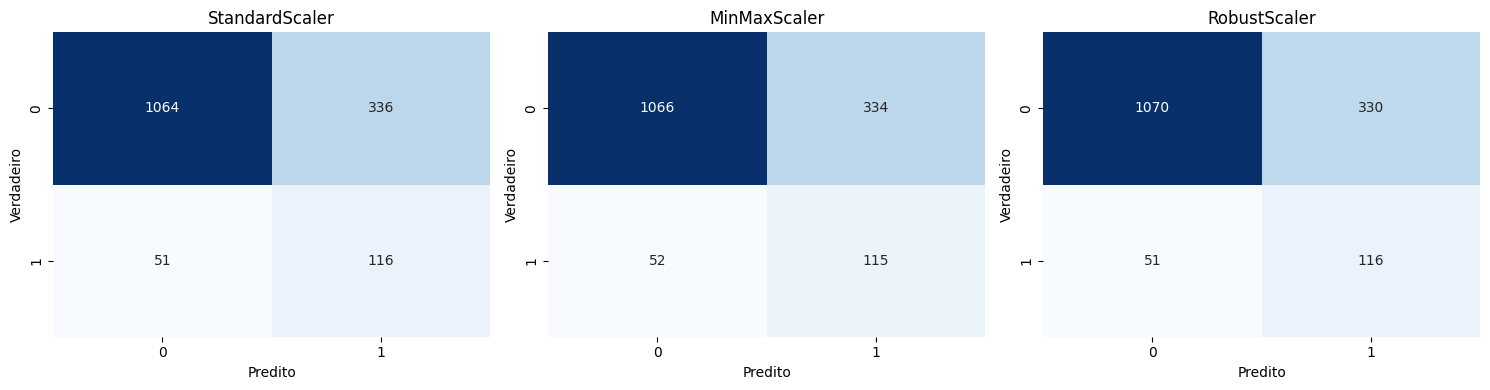

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, (name, y_pred) in zip(axes, y_preds.items()):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)
    ax.set_title(name, fontsize=12)
    ax.set_xlabel('Predito')
    ax.set_ylabel('Verdadeiro')

plt.tight_layout()
plt.show()

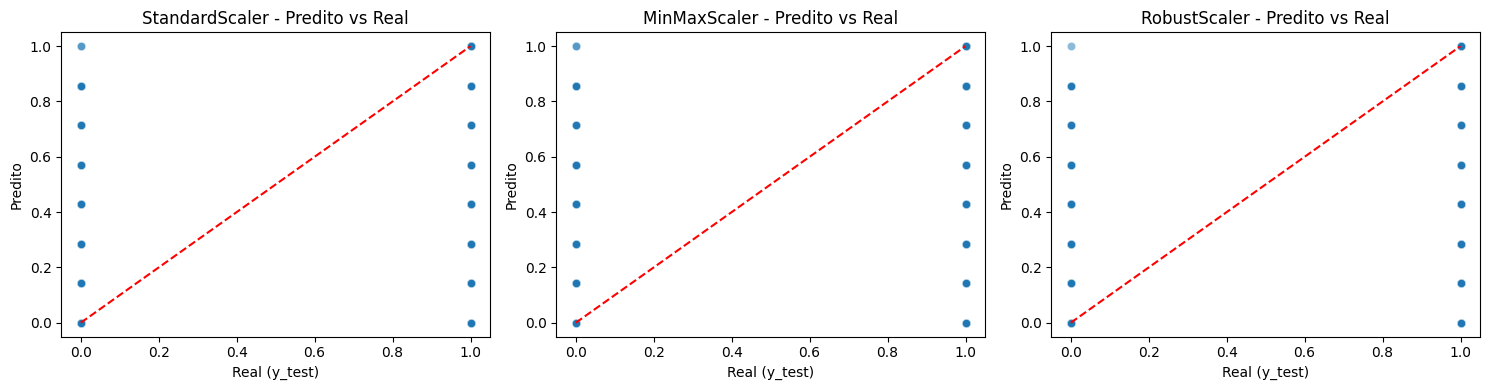

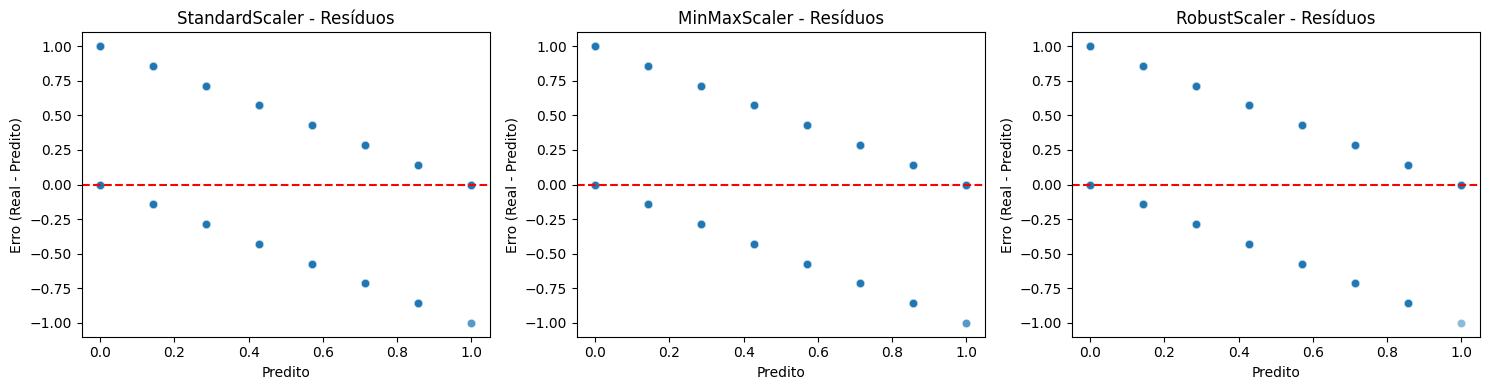

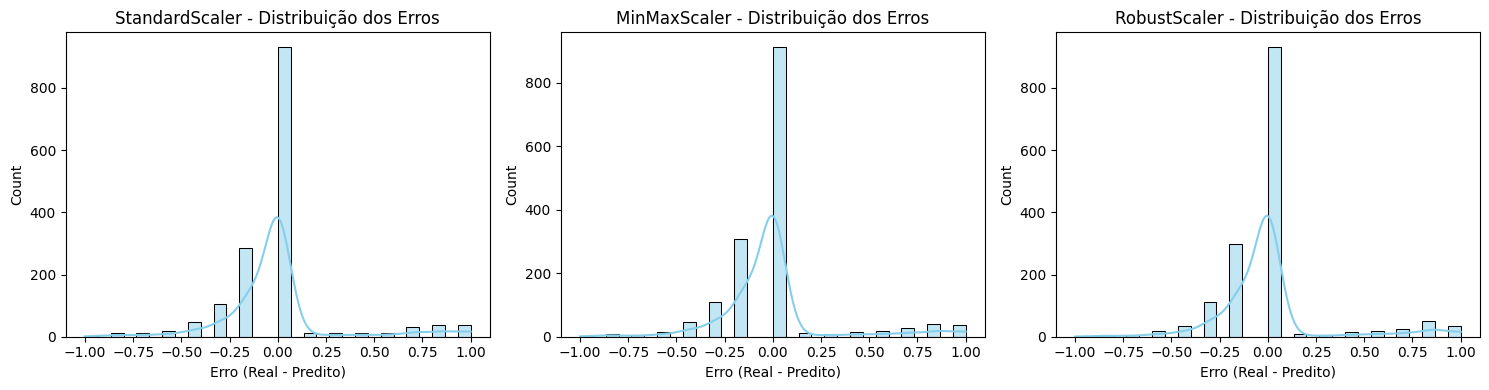

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Armazenar previsões de regressão também (vamos supor que você salve no mesmo loop anterior)
# results_reg[name]["Pred"] = y_pred_reg

# Exemplo: garantir que salvamos as previsões
for name, scaler in scalers.items():
    # (No seu loop anterior, adicione esta linha dentro da parte da regressão:)
    # results_reg[name]["Pred"] = y_pred_reg
    pass

# Plot Predito vs Real
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, (name, res) in zip(axes, results_reg.items()):
    y_pred_reg = res["Pred"]

    sns.scatterplot(x=y_test, y=y_pred_reg, alpha=0.5, ax=ax)
    ax.plot([0, 1], [0, 1], '--', color='red')  # linha de referência
    ax.set_title(f"{name} - Predito vs Real")
    ax.set_xlabel("Real (y_test)")
    ax.set_ylabel("Predito")

plt.tight_layout()
plt.show()


# Plot de Resíduos
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for ax, (name, res) in zip(axes, results_reg.items()):
    y_pred_reg = res["Pred"]
    residuals = y_test - y_pred_reg

    sns.scatterplot(x=y_pred_reg, y=residuals, alpha=0.5, ax=ax)
    ax.axhline(0, linestyle='--', color='red')
    ax.set_title(f"{name} - Resíduos")
    ax.set_xlabel("Predito")
    ax.set_ylabel("Erro (Real - Predito)")

plt.tight_layout()
plt.show()


# Histograma dos erros
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for ax, (name, res) in zip(axes, results_reg.items()):
    y_pred_reg = res["Pred"]
    residuals = y_test - y_pred_reg

    sns.histplot(residuals, bins=30, kde=True, ax=ax, color='skyblue')
    ax.set_title(f"{name} - Distribuição dos Erros")
    ax.set_xlabel("Erro (Real - Predito)")

plt.tight_layout()
plt.show()

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


ROC AUC - KNN com SMOTE: nan
ROC AUC - StatsBomb (Baseline): nan
Brier Score - KNN com SMOTE: 0.2884
Brier Score - StatsBomb (Baseline): 0.0365


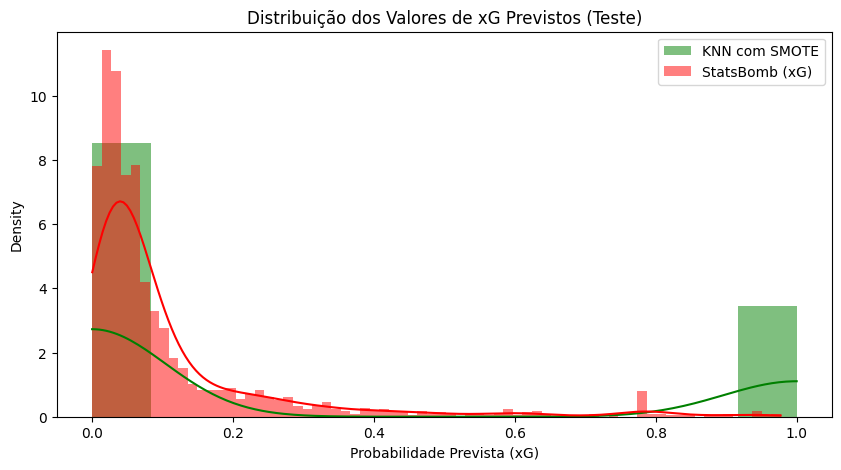


Exemplo das probabilidades previstas (xG) para as primeiras 5 amostras de teste (KNN com SMOTE):
[0 0 0 1 1]

Exemplo das probabilidades previstas (xG) para as primeiras 5 amostras de teste (StatsBomb Baseline):
match_id  event_index
3890383   1113           0.032966
3890317   2785           0.024281
3890564   934            0.151175
3890563   2930           0.060580
3890452   404            0.058541
Name: shot_statsbomb_xg, dtype: float64


In [ ]:
# --- Comparação entre KNN com SMOTE e xG Baseline ---
# Certificando-se de que você tem as previsões de xG (baseline) e do modelo KNN com SMOTE
xg_baseline_test = final_XG_baseline.loc[X_test.index]

# Convertendo y_test para binário (0 ou 1) se ainda não foi feito
y_test_numeric = y_test.apply(lambda x: 1 if x == 'Goal' else 0)

# Certificando-se de que y_pred_baseline seja um valor contínuo (não binário)
y_pred_baseline = xg_baseline_test
y_proba_baseline = xg_baseline_test  # Para o baseline, usamos o xG como probabilidades

# a) ROC AUC para KNN com SMOTE e xG Baseline
roc_auc_knn_smote = roc_auc_score(y_test_numeric, y_preds["StandardScaler"])  # Usando o KNN com SMOTE (StandardScaler aqui como exemplo)
roc_auc_baseline = roc_auc_score(y_test_numeric, y_pred_baseline)

print(f"ROC AUC - KNN com SMOTE: {roc_auc_knn_smote:.4f}")
print(f"ROC AUC - StatsBomb (Baseline): {roc_auc_baseline:.4f}")

# b) Brier Score para KNN com SMOTE e xG Baseline
brier_knn_smote = brier_score_loss(y_test_numeric, y_preds["StandardScaler"])
brier_baseline = brier_score_loss(y_test_numeric, y_pred_baseline)

print(f"Brier Score - KNN com SMOTE: {brier_knn_smote:.4f}")
print(f"Brier Score - StatsBomb (Baseline): {brier_baseline:.4f}")

# --- Comparação Visual (Distribuição dos Valores de xG Previstos) ---
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.histplot(y_preds["StandardScaler"], color='green', label='KNN com SMOTE', kde=True, stat='density', linewidth=0)
sns.histplot(xg_baseline_test, color='red', label='StatsBomb (xG)', kde=True, stat='density', linewidth=0)
plt.title('Distribuição dos Valores de xG Previstos (Teste)')
plt.xlabel('Probabilidade Prevista (xG)')
plt.legend()
plt.show()

# Exemplo das probabilidades previstas (seus valores de xG)
print("\nExemplo das probabilidades previstas (xG) para as primeiras 5 amostras de teste (KNN com SMOTE):")
print(y_preds["StandardScaler"][:5])

print("\nExemplo das probabilidades previstas (xG) para as primeiras 5 amostras de teste (StatsBomb Baseline):")
print(y_proba_baseline[:5])


#### KNN Avaliation - UnderSampling

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

results_class_over = {}
y_preds_over = {}

for name, scaler in scalers.items():
    print(f"\n=== Scaler: {name} ===")

    # Escalar
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Oversampling
    smote = SMOTE(random_state=42)
    X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)
    print(f"After SMOTE -> X_train_res shape: {X_train_res.shape}, y_train_res counts: {np.bincount(y_train_res)}")

    # Treinamento
    clf = KNeighborsClassifier(n_neighbors=7)
    clf.fit(X_train_res, y_train_res)
    y_pred = clf.predict(X_test_scaled)
    y_proba = clf.predict_proba(X_test_scaled)[:,1]

    # Salvar previsões
    y_preds_over[name] = y_pred

    # Métricas
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)
    cm = confusion_matrix(y_test, y_pred)

    results_class_over[name] = {"Accuracy": acc, "F1": f1, "ROC_AUC": auc, "Confusion": cm}

# Mostrar resumo de métricas
print("\n=== Oversampling Metrics ===")
print(pd.DataFrame({k: {"Accuracy": v["Accuracy"], "F1": v["F1"], "ROC_AUC": v["ROC_AUC"]}
                    for k, v in results_class_over.items()}).T)


=== Scaler: StandardScaler ===
After SMOTE -> X_train_res shape: (11188, 27), y_train_res counts: [5594 5594]

=== Scaler: MinMaxScaler ===
After SMOTE -> X_train_res shape: (11188, 27), y_train_res counts: [5594 5594]

=== Scaler: RobustScaler ===
After SMOTE -> X_train_res shape: (11188, 27), y_train_res counts: [5594 5594]

=== Oversampling Metrics ===
                Accuracy        F1   ROC_AUC
StandardScaler  0.753031  0.374798  0.771638
MinMaxScaler    0.753669  0.373377  0.775975
RobustScaler    0.756860  0.378467  0.766970


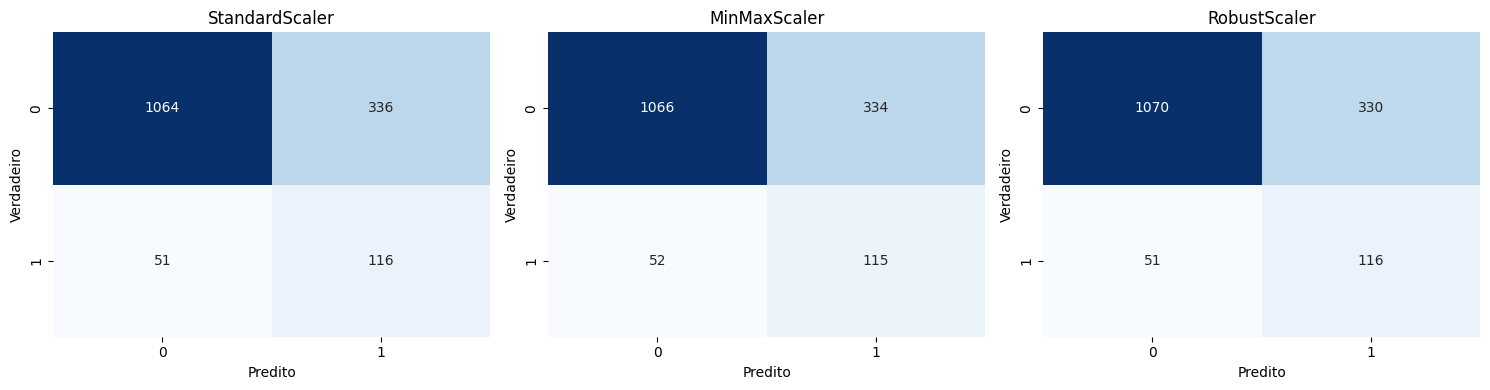

In [ ]:
# Plotar matrizes de confusão
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for ax, (name, y_pred) in zip(axes, y_preds_over.items()):
    cm = results_class_over[name]["Confusion"]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)
    ax.set_title(name)
    ax.set_xlabel('Predito')
    ax.set_ylabel('Verdadeiro')
plt.tight_layout()
plt.show()

#### KNN Avaliation - OverSampling

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

results_class_under = {}
y_preds_under = {}

for name, scaler in scalers.items():
    print(f"\n=== Scaler: {name} ===")

    # Escalar
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Undersampling
    rus = RandomUnderSampler(random_state=42)
    X_train_res, y_train_res = rus.fit_resample(X_train_scaled, y_train)
    print(f"After Undersampling -> X_train_res shape: {X_train_res.shape}, y_train_res counts: {np.bincount(y_train_res)}")

    # Treinamento
    clf = KNeighborsClassifier(n_neighbors=7)
    clf.fit(X_train_res, y_train_res)
    y_pred = clf.predict(X_test_scaled)
    y_proba = clf.predict_proba(X_test_scaled)[:,1]

    # Salvar previsões
    y_preds_under[name] = y_pred

    # Métricas
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)
    cm = confusion_matrix(y_test, y_pred)

    results_class_under[name] = {"Accuracy": acc, "F1": f1, "ROC_AUC": auc, "Confusion": cm}

# Mostrar resumo de métricas
print("\n=== Undersampling Metrics ===")
print(pd.DataFrame({k: {"Accuracy": v["Accuracy"], "F1": v["F1"], "ROC_AUC": v["ROC_AUC"]}
                    for k, v in results_class_under.items()}).T)


=== Scaler: StandardScaler ===
After Undersampling -> X_train_res shape: (1340, 27), y_train_res counts: [670 670]

=== Scaler: MinMaxScaler ===
After Undersampling -> X_train_res shape: (1340, 27), y_train_res counts: [670 670]

=== Scaler: RobustScaler ===
After Undersampling -> X_train_res shape: (1340, 27), y_train_res counts: [670 670]

=== Undersampling Metrics ===
                Accuracy        F1   ROC_AUC
StandardScaler  0.730696  0.364458  0.792066
MinMaxScaler    0.732610  0.364188  0.788520
RobustScaler    0.738354  0.353312  0.776655


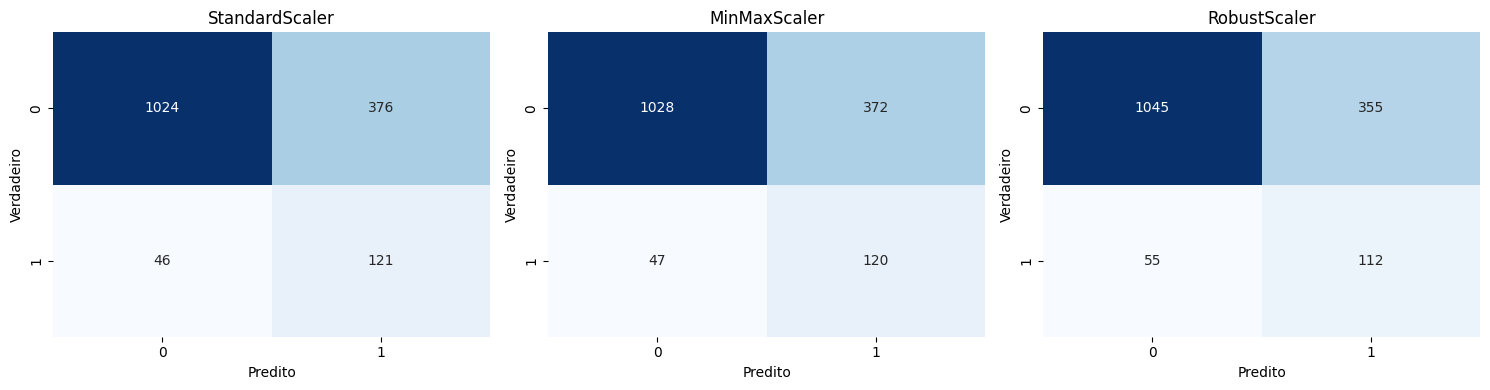

In [ ]:
# Plotar matrizes de confusão
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for ax, (name, y_pred) in zip(axes, y_preds_under.items()):
    cm = results_class_under[name]["Confusion"]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)
    ax.set_title(name)
    ax.set_xlabel('Predito')
    ax.set_ylabel('Verdadeiro')
plt.tight_layout()
plt.show()

#### Random Forest - 1 teste

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

# --- ASSUMPTIONS ---
# 1. Você já tem seus DataFrames/Series finais prontos:
#    - final_X_dataset_scaled: DataFrame com todas as features (já normalizadas e com OHE)
#    - final_Y_labels: Series com as labels ('Goal', 'No Goal')

# --- 1. Divisão dos Dados (Treino e Teste) ---
# Vamos separar 20% dos dados para teste
# random_state garante que a divisão seja a mesma sempre que rodar
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.20,      # 20% para teste
    random_state=42,     # Para reprodutibilidade
    stratify=final_Y_labels # Garante proporção igual de Gols/Não Gols em treino/teste
)

print(f"Tamanho do treino: {X_train.shape[0]} amostras")
print(f"Tamanho do teste: {X_test.shape[0]} amostras")

# --- 2. Criação e Treinamento do Modelo Random Forest Simples ---

# Cria o classificador Random Forest
# n_estimators=100: Número de árvores (um bom default)
# class_weight='balanced': ESSENCIAL para lidar com o desbalanceamento Gol/Não Gol
# random_state=42: Para reprodutibilidade do modelo
rf_model = RandomForestClassifier(
    n_estimators=1000,
    random_state=42,
    n_jobs=-1 # Usa todos os cores da CPU para treinar mais rápido (opcional)
)

print("\nTreinando o modelo Random Forest...")
# Treina o modelo com os dados de treino
rf_model.fit(X_train, y_train)
print("Treinamento concluído.")

# --- 3. Previsões no Conjunto de Teste ---

# Previsão das classes ('Goal' ou 'No Goal')
y_pred = rf_model.predict(X_test)

# Previsão das probabilidades (importante para xG e ROC AUC)
# predict_proba retorna [[prob_NaoGol, prob_Gol], ...]
# Pegamos apenas a probabilidade da classe positiva ('Goal', índice 1)
y_proba = rf_model.predict_proba(X_test)[:, 1]

print("\n--- 4. Avaliação Simples ---")

# Relatório de Classificação (Precision, Recall, F1-Score)
# Mostra o desempenho para cada classe ('Goal', 'No Goal')
print("Relatório de Classificação:")
print(classification_report(y_test, y_pred))

# ROC AUC Score (Área sob a Curva ROC)
# É uma boa métrica geral para problemas desbalanceados
# Precisamos converter 'Goal'/'No Goal' para 1/0 para esta métrica
y_test_numeric = y_test.apply(lambda x: 1 if x == 'Goal' else 0)
roc_auc = roc_auc_score(y_test_numeric, y_proba)
print(f"\nROC AUC Score: {roc_auc:.4f}")

# Exemplo das probabilidades previstas (seus valores de xG)
print("\nExemplo das probabilidades previstas (xG) para as primeiras 5 amostras de teste:")
print(y_proba[:5])

# --- Opcional: Ver as Features Mais Importantes ---
# feature_importances = pd.Series(rf_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
# print("\nImportância das Features:")
# print(feature_importances.head(10)) # Mostra as 10 mais importantes

Tamanho do treino: 6264 amostras
Tamanho do teste: 1567 amostras

Treinando o modelo Random Forest...
Treinamento concluído.

--- 4. Avaliação Simples ---
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.91      0.99      0.95      1400
           1       0.67      0.17      0.27       167

    accuracy                           0.90      1567
   macro avg       0.79      0.58      0.61      1567
weighted avg       0.88      0.90      0.88      1567


ROC AUC Score: nan

Exemplo das probabilidades previstas (xG) para as primeiras 5 amostras de teste:
[0.002 0.019 0.226 0.001 0.22 ]


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Número de amostras no teste: 1567
Número de valores de baseline sincronizados: 1567

--- Comparação de Métricas no Conjunto de Teste ---
ROC AUC - Seu Modelo RF: nan
ROC AUC - StatsBomb Baseline: nan

Brier Score - Seu Modelo RF: 0.0324
Brier Score - StatsBomb Baseline: 0.0292

O baseline tem capacidade de discriminação (ROC AUC) igual ou melhor que seu modelo.
O baseline tem calibração (Brier Score) igual ou melhor que seu modelo.


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


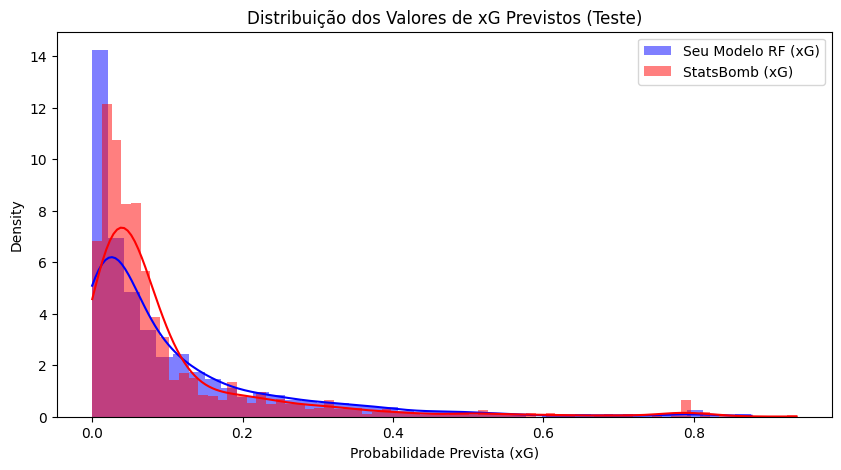

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, brier_score_loss

# --- ASSUMPTIONS ---
# Você já rodou o código anterior e tem:
# - final_X_dataset_scaled: DataFrame de features
# - final_Y_labels: Series de labels ('Goal'/'No Goal')
# - final_XG_baseline: Series com o xG da StatsBomb
# - X_train, X_test, y_train, y_test: Resultado do train_test_split
# - rf_model: Seu modelo Random Forest treinado
# - y_pred: Previsões de classe ('Goal'/'No Goal') do seu modelo no teste
# - y_proba: Probabilidades ('xG') do seu modelo no teste
# - y_test_numeric: y_test convertido para 0/1

# --- 1. Sincronizar o Baseline com o Conjunto de Teste ---

# Use o índice do X_test para selecionar os valores correspondentes do baseline
# Isso garante que estamos comparando exatamente os mesmos chutes
xg_baseline_test = final_XG_baseline.loc[X_test.index]

print(f"Número de amostras no teste: {len(X_test)}")
print(f"Número de valores de baseline sincronizados: {len(xg_baseline_test)}")
# (Os dois números devem ser iguais)

# --- 2. Comparar Métricas (ROC AUC e Brier Score) ---

print("\n--- Comparação de Métricas no Conjunto de Teste ---")

# a) ROC AUC (Mede a capacidade de discriminação - quão bem separa Gols de Não Gols)
#    Quanto maior, melhor (máximo 1.0)
roc_auc_modelo = roc_auc_score(y_test_numeric, y_proba)
roc_auc_baseline = roc_auc_score(y_test_numeric, xg_baseline_test)

print(f"ROC AUC - Seu Modelo RF: {roc_auc_modelo:.4f}")
print(f"ROC AUC - StatsBomb Baseline: {roc_auc_baseline:.4f}")

# b) Brier Score (Mede a calibração - quão "confiantes" estão as probabilidades)
#    Quanto menor, melhor (mínimo 0.0)
brier_modelo = brier_score_loss(y_test_numeric, y_proba)
brier_baseline = brier_score_loss(y_test_numeric, xg_baseline_test)

print(f"\nBrier Score - Seu Modelo RF: {brier_modelo:.4f}")
print(f"Brier Score - StatsBomb Baseline: {brier_baseline:.4f}")

# --- 3. Interpretação ---

if roc_auc_modelo > roc_auc_baseline:
    print("\nSeu modelo tem melhor capacidade de discriminação (ROC AUC) que o baseline.")
else:
    print("\nO baseline tem capacidade de discriminação (ROC AUC) igual ou melhor que seu modelo.")

if brier_modelo < brier_baseline:
    print("Seu modelo tem melhor calibração (Brier Score) que o baseline.")
else:
    print("O baseline tem calibração (Brier Score) igual ou melhor que seu modelo.")

# --- Opcional: Comparação Visual (Histograma das Probabilidades) ---
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.histplot(y_proba, color='blue', label='Seu Modelo RF (xG)', kde=True, stat='density', linewidth=0)
sns.histplot(xg_baseline_test, color='red', label='StatsBomb (xG)', kde=True, stat='density', linewidth=0)
plt.title('Distribuição dos Valores de xG Previstos (Teste)')
plt.xlabel('Probabilidade Prevista (xG)')
plt.legend()
plt.show() # ou plt.savefig('xg_distribution.png')

#### Regressao Logistica

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression  # Importa o modelo
from sklearn.metrics import classification_report, roc_auc_score
from imblearn.over_sampling import SMOTE  # Importa o SMOTE

# --- ASSUMPTIONS ---
# 1. Você já tem seus DataFrames/Series finais prontos:
#    - final_X_dataset_scaled: DataFrame com features (normalizadas e OHE)
#    - final_Y_labels: Series com labels ('Goal', 'No Goal')
# 2. Você já fez a divisão treino/teste:
#    - X_train, X_test, y_train, y_test

# --- 1. Balanceamento de Dados com SMOTE (apenas no conjunto de treino) ---
# Cria o objeto SMOTE
smote = SMOTE(random_state=42)

# Aplica o SMOTE nos dados de treino
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print("\nBalanceamento concluído com SMOTE. Dados de treino ajustados.")

# --- 2. Criação e Treinamento do Modelo de Regressão Logística Simples ---

# Cria o classificador de Regressão Logística
log_reg_model = LogisticRegression(
    random_state=42,
    max_iter=1000  # Pode precisar aumentar se tiver aviso de convergência
)

print("\nTreinando o modelo de Regressão Logística...")
# Treina o modelo com os dados balanceados
log_reg_model.fit(X_train_balanced, y_train_balanced)
print("Treinamento concluído.")

# --- 3. Previsões no Conjunto de Teste ---

# Previsão das classes ('Goal' ou 'No Goal')
y_pred_lr = log_reg_model.predict(X_test)

# Previsão das probabilidades (importante para xG e ROC AUC)
# Pegamos apenas a probabilidade da classe positiva ('Goal', índice 1)
y_proba_lr = log_reg_model.predict_proba(X_test)[:, 1]

print("\n--- 4. Avaliação Simples (Regressão Logística) ---")

# Relatório de Classificação (Precision, Recall, F1-Score)
print("Relatório de Classificação:")
print(classification_report(y_test, y_pred_lr))

# ROC AUC Score
# (Requer y_test numérico 0/1)
y_test_numeric = y_test.apply(lambda x: 1 if x == 'Goal' else 0)
roc_auc_lr = roc_auc_score(y_test_numeric, y_proba_lr)
print(f"\nROC AUC Score: {roc_auc_lr:.4f}")

# Exemplo das probabilidades previstas (seus valores de xG)
print("\nExemplo das probabilidades previstas (xG) pela Regressão Logística:")
print(y_proba_lr[:5])



Balanceamento concluído com SMOTE. Dados de treino ajustados.

Treinando o modelo de Regressão Logística...
Treinamento concluído.

--- 4. Avaliação Simples (Regressão Logística) ---
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.94      0.90      0.92      1400
           1       0.38      0.52      0.44       167

    accuracy                           0.86      1567
   macro avg       0.66      0.71      0.68      1567
weighted avg       0.88      0.86      0.87      1567


ROC AUC Score: nan

Exemplo das probabilidades previstas (xG) pela Regressão Logística:
[0.03532462 0.09424965 0.55377831 0.09894584 0.38678127]


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Número de amostras no teste: 1567
Número de valores de baseline sincronizados: 1567

--- Comparação de Métricas no Conjunto de Teste ---
ROC AUC - Sua Regressão Logística: nan
ROC AUC - StatsBomb Baseline: nan

Brier Score - Sua Regressão Logística: 0.1158
Brier Score - StatsBomb Baseline: 0.0365

O baseline tem capacidade de discriminação (ROC AUC) igual ou melhor que sua Regressão Logística.
O baseline tem calibração (Brier Score) igual ou melhor que sua Regressão Logística.


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


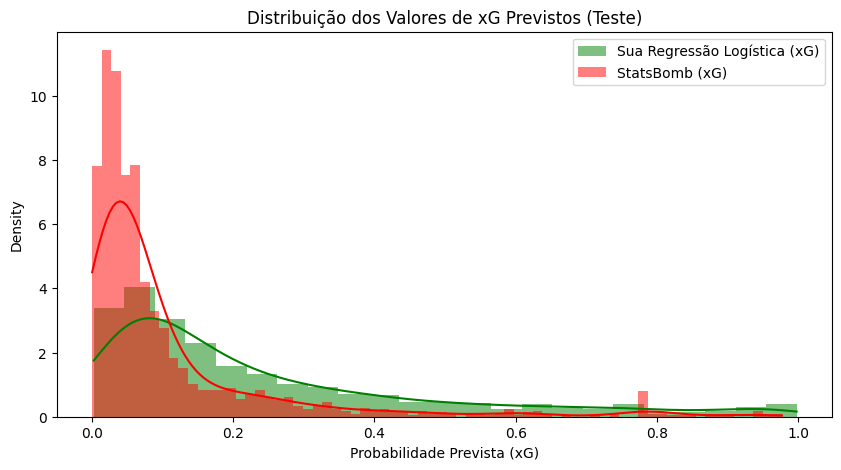

In [ ]:
from sklearn.metrics import brier_score_loss # Importa Brier Score

# --- ASSUMPTIONS ---
# Você já rodou a Célula 1 e tem:
# - final_XG_baseline: Series com o xG da StatsBomb
# - X_test: DataFrame de teste
# - y_test_numeric: Labels de teste (0/1)
# - y_proba_lr: Probabilidades ('xG') da sua Regressão Logística no teste

# --- 1. Sincronizar o Baseline com o Conjunto de Teste ---
# (Garante que estamos comparando os mesmos chutes)
xg_baseline_test = final_XG_baseline.loc[X_test.index]

print(f"Número de amostras no teste: {len(X_test)}")
print(f"Número de valores de baseline sincronizados: {len(xg_baseline_test)}")

# --- 2. Comparar Métricas (ROC AUC e Brier Score) ---

print("\n--- Comparação de Métricas no Conjunto de Teste ---")

# a) ROC AUC (Discriminação)
# (Já calculamos roc_auc_lr na célula anterior)
roc_auc_baseline = roc_auc_score(y_test_numeric, xg_baseline_test)

print(f"ROC AUC - Sua Regressão Logística: {roc_auc_lr:.4f}")
print(f"ROC AUC - StatsBomb Baseline: {roc_auc_baseline:.4f}")

# b) Brier Score (Calibração - quanto menor, melhor)
brier_lr = brier_score_loss(y_test_numeric, y_proba_lr)
brier_baseline = brier_score_loss(y_test_numeric, xg_baseline_test)

print(f"\nBrier Score - Sua Regressão Logística: {brier_lr:.4f}")
print(f"Brier Score - StatsBomb Baseline: {brier_baseline:.4f}")

# --- 3. Interpretação ---

if roc_auc_lr > roc_auc_baseline:
    print("\nSua Regressão Logística tem melhor capacidade de discriminação (ROC AUC) que o baseline.")
else:
    print("\nO baseline tem capacidade de discriminação (ROC AUC) igual ou melhor que sua Regressão Logística.")

if brier_lr < brier_baseline:
    print("Sua Regressão Logística tem melhor calibração (Brier Score) que o baseline.")
else:
    print("O baseline tem calibração (Brier Score) igual ou melhor que sua Regressão Logística.")

# --- Opcional: Comparação Visual (Histograma) ---
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.histplot(y_proba_lr, color='green', label='Sua Regressão Logística (xG)', kde=True, stat='density', linewidth=0)
sns.histplot(xg_baseline_test, color='red', label='StatsBomb (xG)', kde=True, stat='density', linewidth=0)
plt.title('Distribuição dos Valores de xG Previstos (Teste)')
plt.xlabel('Probabilidade Prevista (xG)')
plt.legend()
plt.show() # ou plt.savefig('xg_distribution_lr.png')

# final_Y_labels, final_X_dataset_scaled, final_XG_baseline

In [ ]:
final_Y_labels = final_Y_labels.map({'Goal': 1, 'No Goal': 0})

In [ ]:
final_Y_labels.head()

match_id  event_index
3890561   262            0
          352            1
          409            0
          623            1
          748            0
Name: shot_outcome_id, dtype: int64

In [ ]:
final_X_dataset_scaled.head()

f1_dist_goal  f2_angle_goal  f3_dist_gk  f4_centrality  f5_pos_x  f6_min_dist_def  f7_pressure_effective  f8_pressure_possible  f9_min_dist_ra  f10_blockers_traj  f12_gk_on_traj  f13_def_compactness  tech_89.0  tech_90.0  tech_91.0  tech_92.0  tech_93.0  tech_94.0  tech_95.0  tech_96.0  tech_97.0  tech_98.0  tech_100.0  body_37.0  body_38.0  body_40.0  body_46.0
match_id event_index                                                                                                                                                                                                                                                                                                                                                                              
3890561  262             14.800338      25.119534   13.231024            8.8     108.1         5.020956                      0                     0        3.520956                  2            True            12.060086          0          0          1          0          0          0          0          0          0          0           0          0          1          0          0
         352              9.464143      44.698590    5.135173            2.6     110.9         1.552417                      1                     2        0.052417                  0            True             9.476143          0          0          0          0          0          0          1          0          0          0           0          0          0          1          0
         409             11.100450       8.905109   10.124228           10.9     117.9         1.216553                      1                     1       -0.283447                  1            True             9.444475          0          0          1          0          0          0          0          0          0          0           0          0          1          0          0
         623             22.022716      17.246839    4.866210           12.4     101.8         7.874643                      0                     0        6.374643                  0           False             9.700110          0          0          0          0          1          0          0          0          0          0           0          0          1          0          0
         748             17.226143      16.956907   13.453624           13.5     109.3         2.473863                      1                     1        0.973863                  1            True             7.126313          0          0          0          0          1          0          0          0          0          0           0          0          0          1          0

In [ ]:
final_XG_baseline.head()

match_id  event_index
3890561   262            0.087901
          352            0.160274
          409            0.016036
          623            0.527759
          748            0.074020
Name: shot_statsbomb_xg, dtype: float64

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Salvando dentro do drive as 3 partes do dataset
from google.colab import drive
drive.mount('/content/drive')

caminho_drive = '/content/drive/MyDrive/xG/'

y_train.to_csv(caminho_drive + 'y_train.csv', index=False)
y_test.to_csv(caminho_drive + 'y_test.csv', index=False)
X_train.to_csv(caminho_drive + 'X_train_.csv', index=False)
X_test.to_csv(caminho_drive + 'X_test_.csv', index=False)

print(f"Arquivos CSV salvos permanentemente em: {caminho_drive}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Arquivos CSV salvos permanentemente em: /content/drive/MyDrive/xG/
